# Data Centric - ML Approaches

The goal here is to see how data intricacies affect the outcome of models. Other common problems we will be trying to address are: class imbalance and overfitting. 

-------
-------

In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

Downloading the two datasets, the pretrained models and histories:

In [2]:
# Cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# Download pretrained models and training histories
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

--2022-08-22 09:12:04--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   236MB/s    in 3.5s    

2022-08-22 09:12:08 (228 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2022-08-22 09:12:08--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1259479040 

Combining the datasets

In [3]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

Extracting the data into a directory, `base_dir`.

Note that the `cats vs dogs` images are in `zip` file format while the `caltech birds` images come in a `tar` file.

In [4]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

In [5]:
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

For the cats and dogs images no further preprocessing is needed as all exemplars of a single class are located in one directory: `PetImages\Cat` and `PetImages\Dog` respectively. check size of each category:

In [6]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


The Bird images dataset.

In [7]:
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


LetQuick look at an image of each class we are trying to predict.

Sample cat image:


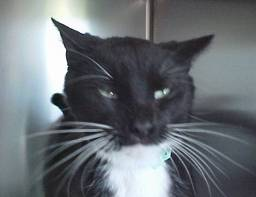


Sample dog image:


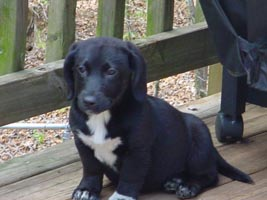


Sample bird image:


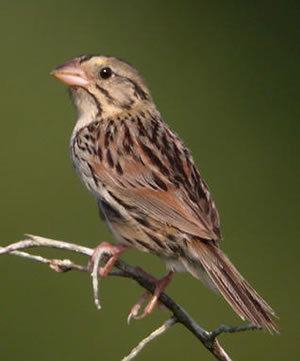

In [8]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

## Train / Evaluate Split

In [10]:
# create directories for train and test sets
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

In [11]:
# function that moves a percentage of images from an origin folder to a destination folder
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

In [12]:
# split data
# 70% of the images to the train dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)


# remaining images go to the eval dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

Current issues with the data we have:

1. Some images are corrupted and have zero bytes.
2. Cats vs dogs zip file included a `.db` file for each class that needs to be deleted.

In [13]:
!find /tmp/data/ -size 0 -exec rm {} +
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +

In [14]:
# final file seizes
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


#### To Address Imbalance Issues 

In [16]:
# Create directory called imbalanced
for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, 'imbalanced/'+dir)):
    os.makedirs(os.path.join(base_dir, 'imbalanced/'+dir))

In [17]:
# function to copy data
def copy_with_limit(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

# Perform the copying
copy_with_limit(os.path.join(base_dir, 'train/cats'), os.path.join(base_dir, 'imbalanced/train/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'train/dogs'), os.path.join(base_dir, 'imbalanced/train/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'train/birds'), os.path.join(base_dir, 'imbalanced/train/birds'), 0.1)

copy_with_limit(os.path.join(base_dir, 'eval/cats'), os.path.join(base_dir, 'imbalanced/eval/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'eval/dogs'), os.path.join(base_dir, 'imbalanced/eval/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'eval/birds'), os.path.join(base_dir, 'imbalanced/eval/birds'), 0.1)

# Print number of available images
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1749 images of dogs for training
There are 825 images of birds for training

There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


## Selecting the model

Create a model architecture and define a loss function, optimizer and performance metrics leveraging keras API:

In [18]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # A simple CNN architecture based on the one found here: https://www.tensorflow.org/tutorials/images/classification
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

Model summary as a quick check.

In [19]:
# Create a model to use with the imbalanced dataset
imbalanced_model = create_model()

# Print the model's summary
print(imbalanced_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

For training the model we will use Keras' ImageDataGenerator, which has built-in functionalities to easily feed the model with raw, rescaled or even augmented image data.

Another cool functionality within ImageDataGenerator is the `flow_from_directory` method which allows to read images as needed from a root directory. This method needs the following arguments:

- `directory`: Path to the root directory where the images are stored.
- `target_size`: The dimensions to which all images found will be resized. Since images come in all kinds of resolutions, you need to standardize their size. 150x150 is used but other values should work well too.
- `batch_size`: Number of images the generator yields everytime it is asked for a next batch. 32 is used here.
- `class_mode`: How the labels are represented. Here "binary" is used to indicate that labels will be 1D. This is done for compatibility with the loss and evaluation metrics used when compiling the model.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/imbalanced/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/imbalanced/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 11324 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


check that both generators (training and validation) use the same labels for each class:

In [21]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}



# Training a CNN with class imbalanced data


In [22]:
# Load pretrained model and history

imbalanced_history = pd.read_csv('history-imbalanced/history-imbalanced.csv')
imbalanced_model = tf.keras.models.load_model('model-imbalanced')

In [23]:
# to train the model

# imbalanced_history = imbalanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

Performance metrics

In [24]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

plot metrics

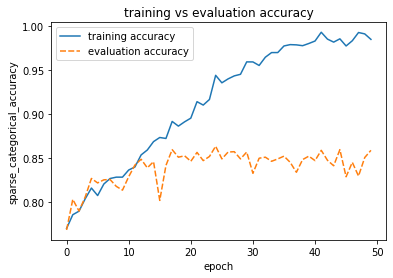

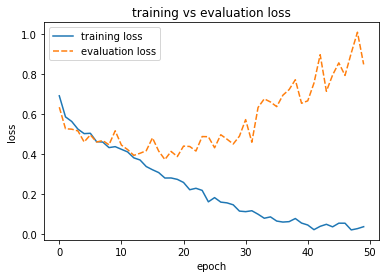

In [25]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()



plot_train_eval(imbalanced_history)

The model is overfitting the training data. However, the evaluation accuracy is still pretty high. 

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [27]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 4852 images belonging to 3 classes.


In [28]:
# Get the true labels 
y_true = val_gen_no_shuffle.classes

# Use the model to predict 
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax 
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

Accuracy Score: 0.855111294311624
Balanced Accuracy Score: 0.7417486453422518


Comparing the `accuracy` and `balanced accuracy` metrics, the class imbalance starts to become visible. 

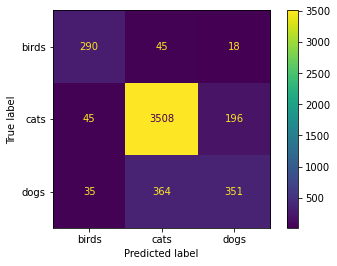

In [29]:
# confusion matrix
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [30]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 21.62%
Proportion of misclassified cats: 10.44%
Proportion of misclassified dogs: 37.88%


Class imbalance is a real problem that if not detected early on, gives the wrong impression that your model is performing better than it actually is. 

In [31]:
# Predict cat for all images
all_cats = np.ones(y_true.shape)

# accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.7726710634789777
Balanced Accuracy Score: 0.3333333333333333


Found 11036 images belonging to 3 classes.


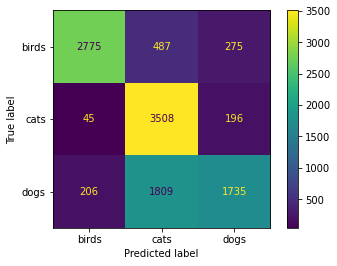

In [32]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict 
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax 
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Confusion matrix
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

### Training with the complete dataset


In [33]:
# model to use with the balanced dataset
balanced_model = create_model()

In [34]:
# no data augmentation, only re-scaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to the complete dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [35]:
# pretrained model and history

balanced_history = pd.read_csv('history-balanced/history-balanced.csv')
balanced_model = tf.keras.models.load_model('model-balanced')

In [ ]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# balanced_history = balanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

check how the `accuracy` vs `balanced accuracy` comparison looks like now:

In [36]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 11036 images belonging to 3 classes.


In [37]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict 
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

# Get the argmax 
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8636281261326567
Balanced Accuracy Score: 0.8647221799730266


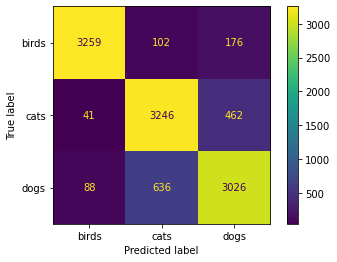

In [38]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

Both accuracy-based metrics are very similar now. The confusion matrix also looks way better than before. This suggests that class imbalance has been successfully mitigated by adding more data to the previously undersampled classes.


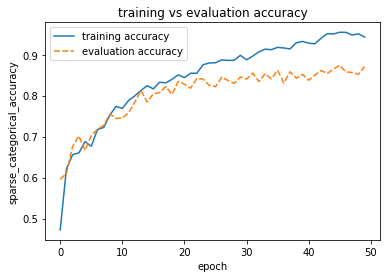

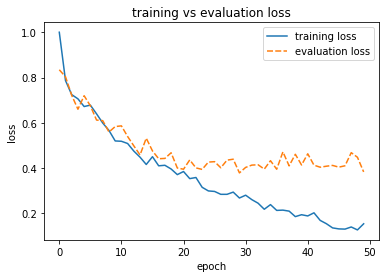

In [39]:
# plot
plot_train_eval(balanced_history)

# Training with Data Augmentation

Augmenting images is a technique in which you create new versions of the images you have at hand, by applying geometric transformations. These transformations can vary from: zooming in and out, rotating, or even flipping the images. By doing this, you get a training dataset that exposes the model to a wider variety of images. This helps in further exploring the feature space and hence reducing the chances of overfitting. 


In [40]:
# Create a model to use with the balanced and augmented dataset
augmented_model = create_model()

In [41]:
#  image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

#  directory with full dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.



Transformation number: 0



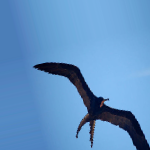


Transformation number: 1



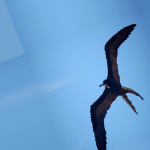


Transformation number: 2



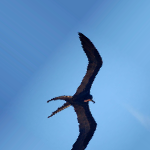


Transformation number: 3



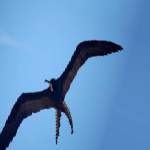

In [42]:
# displays different transformations for a single image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


# Displays transformations on random images of birds in the training partition
def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)


# An example of an ImageDataGenerator
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True)

display_transformations(sample_gen)

Let's look at another more extreme example:


Transformation number: 0



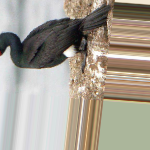


Transformation number: 1



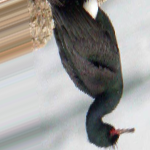


Transformation number: 2



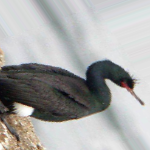


Transformation number: 3



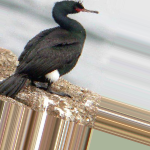

In [43]:
# An ImageDataGenerator with more extreme data augmentation
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.5,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True)

display_transformations(sample_gen)

In [44]:
# Load pretrained model and history

augmented_history = pd.read_csv('history-augmented/history-augmented.csv')
augmented_model = tf.keras.models.load_model('model-augmented')

Since you know that class imbalance is no longer an issue there is no need to check for more in-depth metrics. 

Let's plot the training history right away:

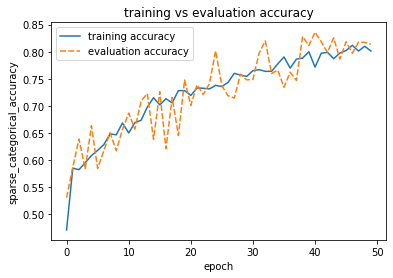

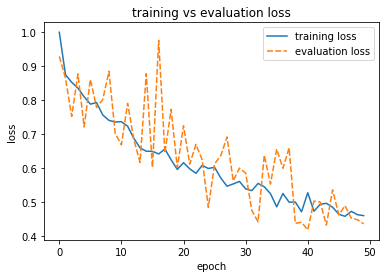

In [45]:
plot_train_eval(augmented_history)

The evaluation accuracy follows more closely the training one. This indicates that **the model is no longer overfitting**.

Also, this model achieves a slightly lower evaluation accuracy when compared to the model without data augmentation. The reason for this, is that this model needs more epochs to train.  
